In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Flatten, MaxPooling2D, Reshape, LeakyReLU, Dropout, Input
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model

Using TensorFlow backend.


In [4]:
import pickle as pkl
with open("dataset_shuf.pkl", "rb") as f:
    dataset_shuf = pkl.load(f)

## Split into test and training sets

In [5]:
test_ratio = 0.1
tot_num_images=29710
test_size = int(test_ratio*tot_num_images)

test_lab = dataset_shuf[0][:test_size]
test_img = dataset_shuf[2][:test_size]

train_lab = dataset_shuf[0][test_size:]
train_img = dataset_shuf[2][test_size:]

dataset = [(train_img,train_lab),(test_img,test_lab)]

## Model Builder

In [6]:
def define_basic_classifier():
    image_input = Input(shape=(64,64,3))
    x = Conv2D(16, (3, 3), strides=2)(image_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), strides=2)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), strides=2)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    output = Dense(20, activation='softmax')(x)
  
    model = Model([image_input],output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model
 
def VGG16_based(learning_rate):
    image_input = Input(shape=(64,64,3))
    #1
    x = Conv2D(32, (3, 3), strides=1, name='c1',padding='same')(image_input)
    x = LeakyReLU(0.2)(x)
    #2
    x = Conv2D(32, (3, 3), strides=1, name='c2')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #3
    x = Conv2D(64, (3, 3), strides=1, name='c3', padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #4
    x = Conv2D(64, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #5
    x = Conv2D(128, (3, 3), strides=1,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #6
    x = Conv2D(128, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #7
    x = Conv2D(256, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #8
    x = Conv2D(256, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
  
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    output = Dense(20, activation='softmax')(x)
  
    model = Model(image_input,output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    
    return model
  
# Plotting the model  
#classifier =  VGG16_based()
#plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Training

In [7]:
def train(num_epochs,batch_size, classifier,dataset):
    (x_train, y_train), (x_test, y_test) = dataset


  
    batches_per_epo = int(x_train.shape[0]/batch_size)
  
    c_train_acc_array = np.array([])
    c_test_acc_array = np.array([])

    for epoch in range(num_epochs):
        for batch in range(batches_per_epo):
            # Get a batch of images (x) and labels (y)
            x_train_batch = x_train[batch*batch_size : (batch+1)*batch_size]
            y_train_batch = y_train[batch*batch_size : (batch+1)*batch_size]
            # Train classifier
            c_train_loss, train_accuracy = classifier.train_on_batch(x_train_batch, y_train_batch)
    
    
        # test on the full test set
        c_test_loss, test_accuracy = classifier.test_on_batch(x_test, y_test)
    
        c_train_acc_array = np.append(c_train_acc_array, train_accuracy)
        c_test_acc_array = np.append(c_test_acc_array, test_accuracy)


        k = c_test_acc_array.shape[0]
        x_axis = np.linspace(1, k, k)    

        # Print progress
        print('Epoch: ', epoch+1, ',', ' test_accuracy: ', test_accuracy, ', training accuracy: ', train_accuracy, '.')
        j=1  
        if batch % j == 0:
            
            print("Performance:")
            plt.plot(x_axis, c_train_acc_array, label='train accuracy', linewidth=1)
            plt.plot(x_axis, c_test_acc_array, label='test accuracy', linewidth=1)
            plt.legend()
            plt.xlabel('Number of epochs')
            plt.ylabel('Accuracy')
            plt.show()
        classifier.save('VGG16_based_classifier_bs_lr.h5')

Epoch:  1 ,  test_accuracy:  0.063278355 , training accuracy:  0.060546875 .
Performance:


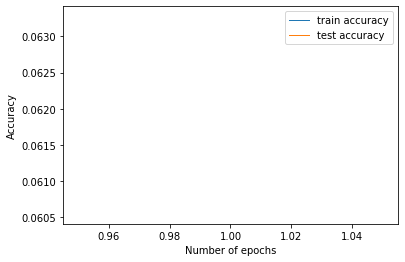

Epoch:  2 ,  test_accuracy:  0.060585663 , training accuracy:  0.103515625 .
Performance:


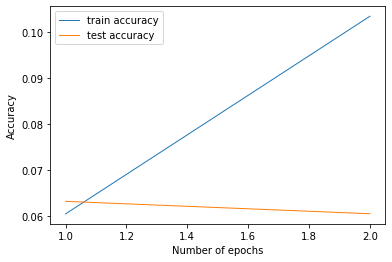

Epoch:  3 ,  test_accuracy:  0.08751262 , training accuracy:  0.099609375 .
Performance:


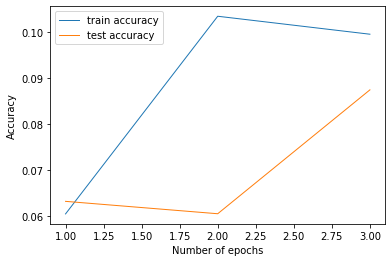

Epoch:  4 ,  test_accuracy:  0.15516661 , training accuracy:  0.13085938 .
Performance:


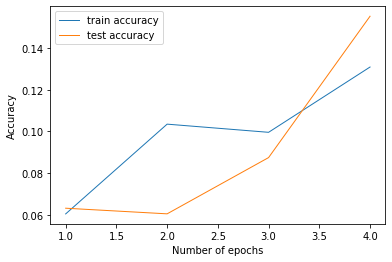

Epoch:  5 ,  test_accuracy:  0.21440592 , training accuracy:  0.17382812 .
Performance:


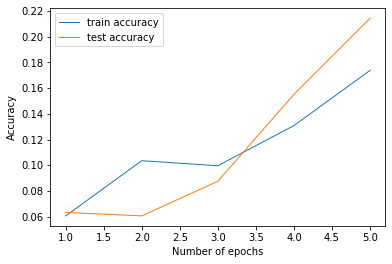

Epoch:  6 ,  test_accuracy:  0.24671827 , training accuracy:  0.24121094 .
Performance:


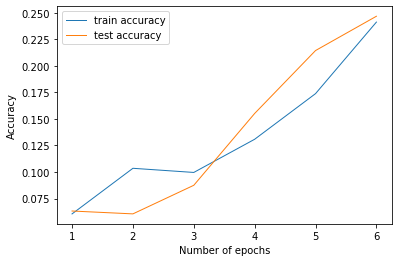

Epoch:  7 ,  test_accuracy:  0.28037697 , training accuracy:  0.2685547 .
Performance:


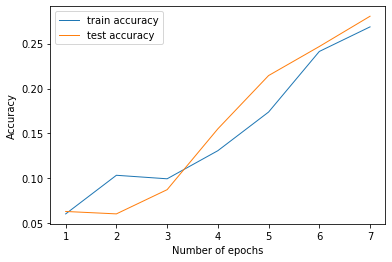

Epoch:  8 ,  test_accuracy:  0.31504545 , training accuracy:  0.29003906 .
Performance:


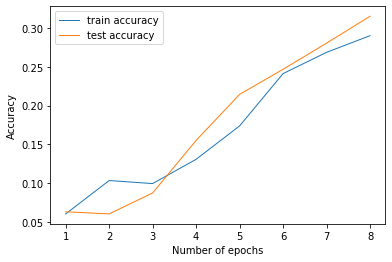

Epoch:  9 ,  test_accuracy:  0.3315382 , training accuracy:  0.3310547 .
Performance:


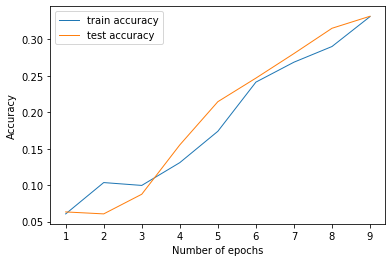

Epoch:  10 ,  test_accuracy:  0.37327498 , training accuracy:  0.40234375 .
Performance:


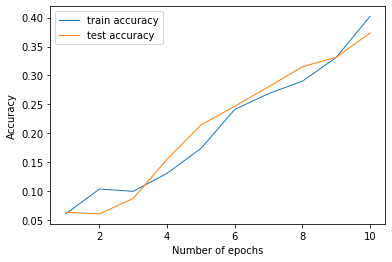

Epoch:  11 ,  test_accuracy:  0.43655336 , training accuracy:  0.421875 .
Performance:


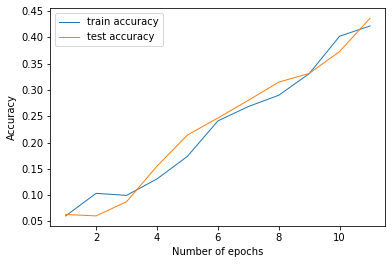

Epoch:  12 ,  test_accuracy:  0.44092897 , training accuracy:  0.4501953 .
Performance:


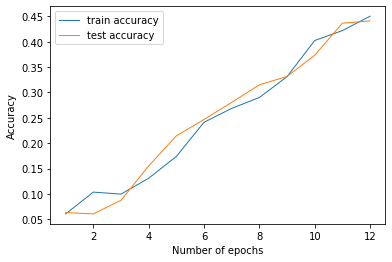

Epoch:  13 ,  test_accuracy:  0.46078762 , training accuracy:  0.47265625 .
Performance:


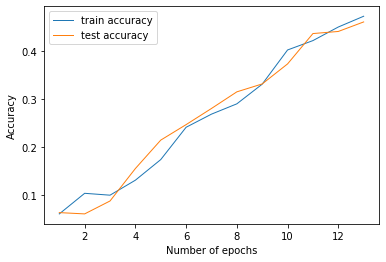

Epoch:  14 ,  test_accuracy:  0.49040726 , training accuracy:  0.49804688 .
Performance:


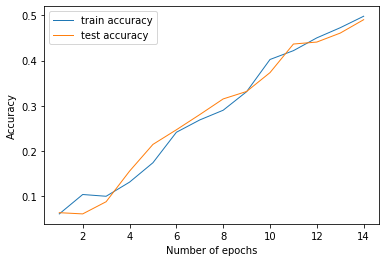

Epoch:  15 ,  test_accuracy:  0.49040726 , training accuracy:  0.5 .
Performance:


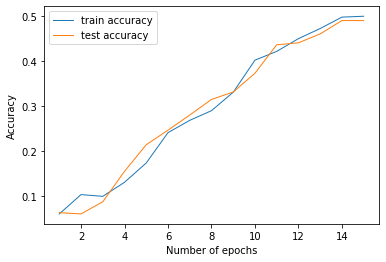

Epoch:  16 ,  test_accuracy:  0.49242678 , training accuracy:  0.52246094 .
Performance:


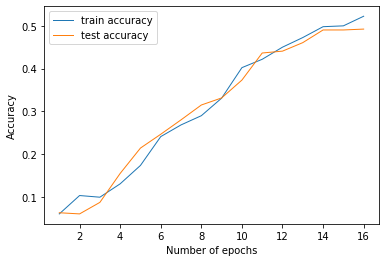

Epoch:  17 ,  test_accuracy:  0.54089534 , training accuracy:  0.5332031 .
Performance:


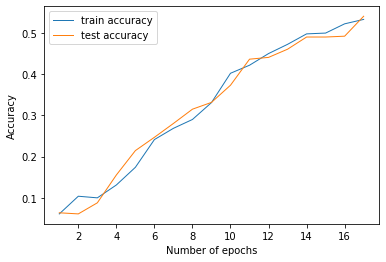

Epoch:  18 ,  test_accuracy:  0.5361831 , training accuracy:  0.55566406 .
Performance:


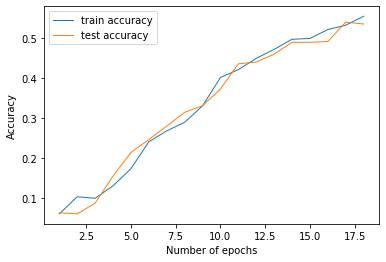

Epoch:  19 ,  test_accuracy:  0.5698418 , training accuracy:  0.59765625 .
Performance:


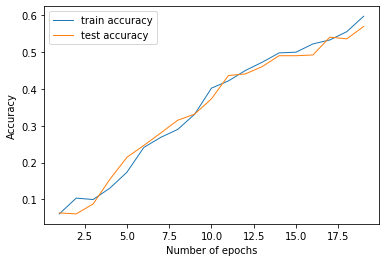

Epoch:  20 ,  test_accuracy:  0.5866712 , training accuracy:  0.59277344 .
Performance:


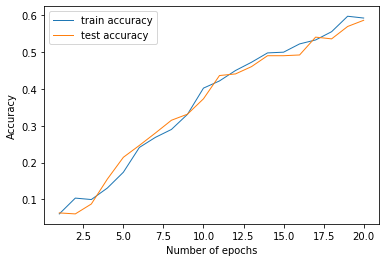

Epoch:  21 ,  test_accuracy:  0.5371929 , training accuracy:  0.61035156 .
Performance:


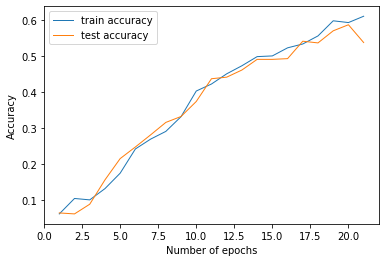

Epoch:  22 ,  test_accuracy:  0.57152474 , training accuracy:  0.609375 .
Performance:


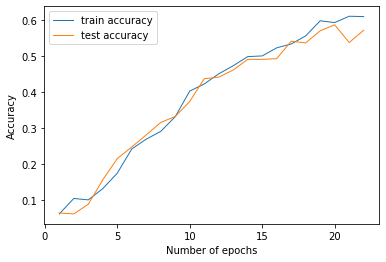

Epoch:  23 ,  test_accuracy:  0.5910468 , training accuracy:  0.63671875 .
Performance:


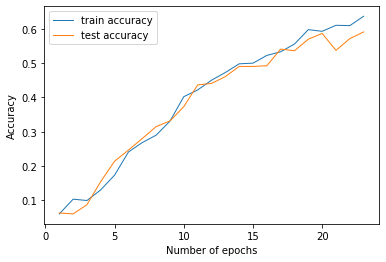

Epoch:  24 ,  test_accuracy:  0.6001346 , training accuracy:  0.61816406 .
Performance:


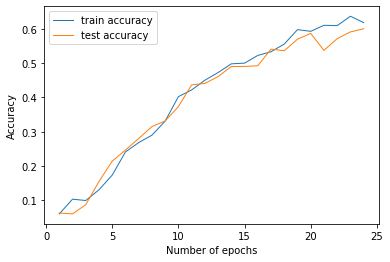

Epoch:  25 ,  test_accuracy:  0.6001346 , training accuracy:  0.6347656 .
Performance:


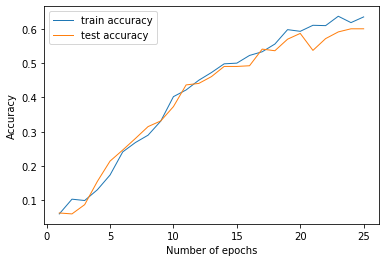

Epoch:  26 ,  test_accuracy:  0.6270616 , training accuracy:  0.6513672 .
Performance:


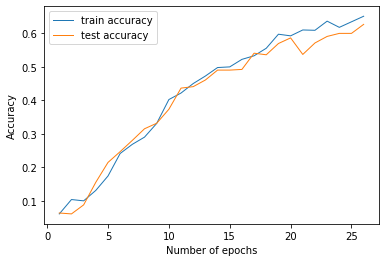

Epoch:  27 ,  test_accuracy:  0.6348031 , training accuracy:  0.6347656 .
Performance:


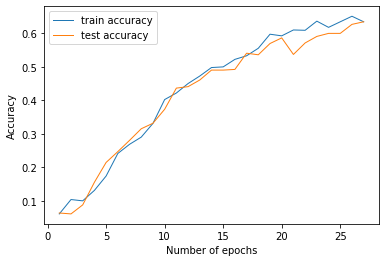

Epoch:  28 ,  test_accuracy:  0.6351397 , training accuracy:  0.640625 .
Performance:


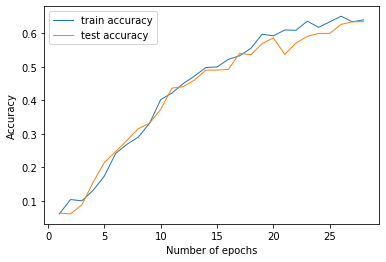

Epoch:  29 ,  test_accuracy:  0.6580276 , training accuracy:  0.64746094 .
Performance:


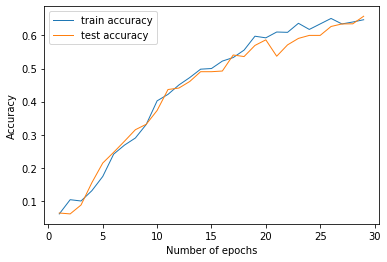

Epoch:  30 ,  test_accuracy:  0.6411983 , training accuracy:  0.6542969 .
Performance:


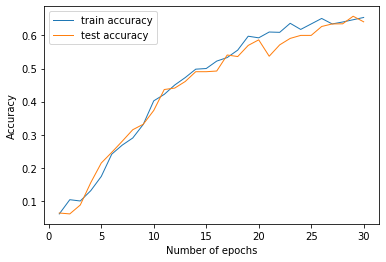

Epoch:  31 ,  test_accuracy:  0.6681252 , training accuracy:  0.6748047 .
Performance:


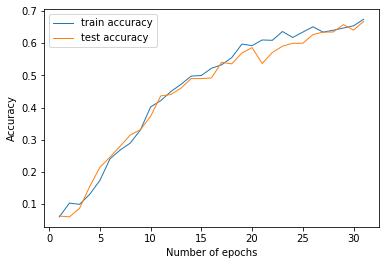

Epoch:  32 ,  test_accuracy:  0.6627398 , training accuracy:  0.6796875 .
Performance:


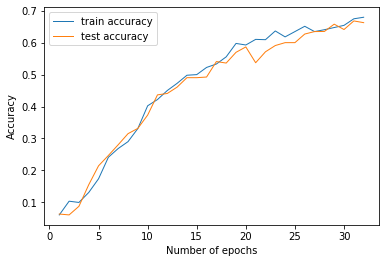

Epoch:  33 ,  test_accuracy:  0.63110065 , training accuracy:  0.6875 .
Performance:


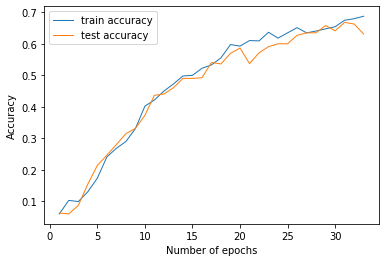

Epoch:  34 ,  test_accuracy:  0.6556715 , training accuracy:  0.6767578 .
Performance:


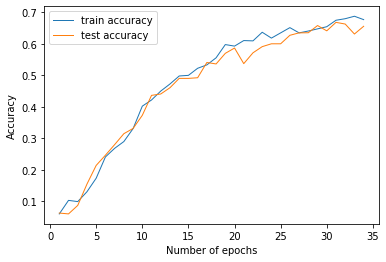

Epoch:  35 ,  test_accuracy:  0.6687984 , training accuracy:  0.6875 .
Performance:


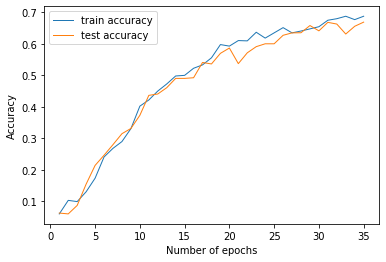

Epoch:  36 ,  test_accuracy:  0.6842814 , training accuracy:  0.7001953 .
Performance:


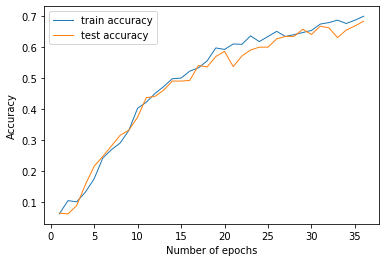

Epoch:  37 ,  test_accuracy:  0.6849546 , training accuracy:  0.7128906 .
Performance:


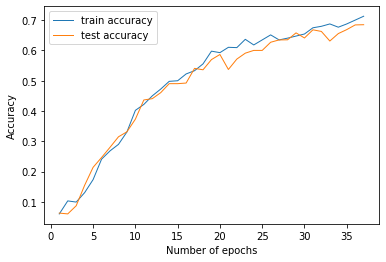

Epoch:  38 ,  test_accuracy:  0.6893302 , training accuracy:  0.7236328 .
Performance:


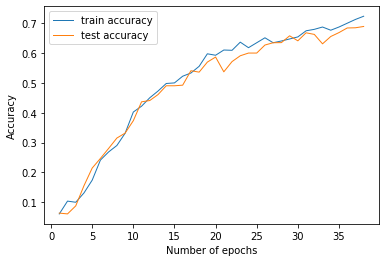

Epoch:  39 ,  test_accuracy:  0.70010096 , training accuracy:  0.6923828 .
Performance:


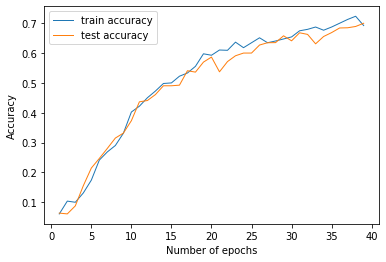

Epoch:  40 ,  test_accuracy:  0.69235945 , training accuracy:  0.703125 .
Performance:


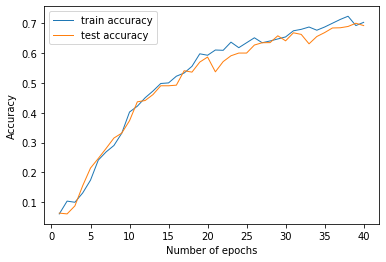

Epoch:  41 ,  test_accuracy:  0.7038034 , training accuracy:  0.73046875 .
Performance:


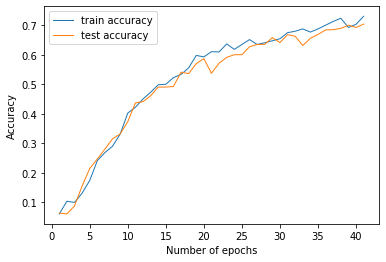

Epoch:  42 ,  test_accuracy:  0.70851564 , training accuracy:  0.7089844 .
Performance:


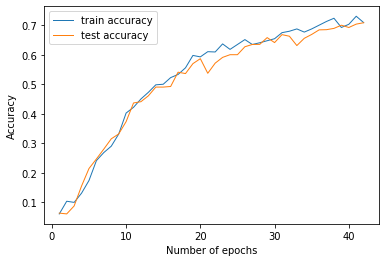

Epoch:  43 ,  test_accuracy:  0.7048132 , training accuracy:  0.73339844 .
Performance:


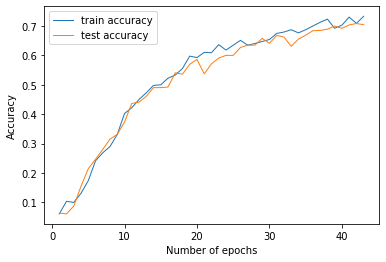

Epoch:  44 ,  test_accuracy:  0.70615953 , training accuracy:  0.71972656 .
Performance:


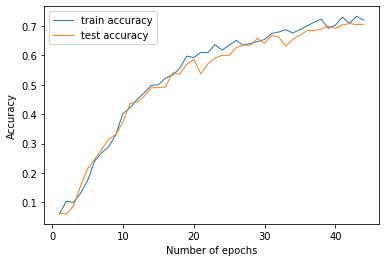

Epoch:  45 ,  test_accuracy:  0.6937058 , training accuracy:  0.7324219 .
Performance:


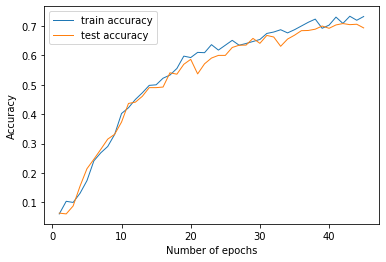

Epoch:  46 ,  test_accuracy:  0.69808143 , training accuracy:  0.7236328 .
Performance:


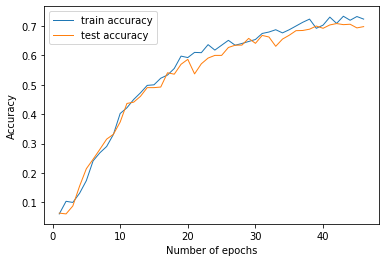

Epoch:  47 ,  test_accuracy:  0.6940424 , training accuracy:  0.7314453 .
Performance:


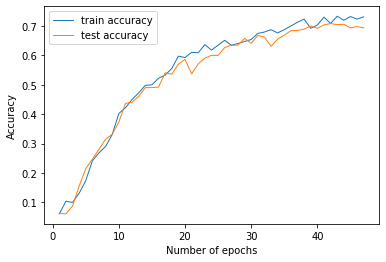

Epoch:  48 ,  test_accuracy:  0.6849546 , training accuracy:  0.72558594 .
Performance:


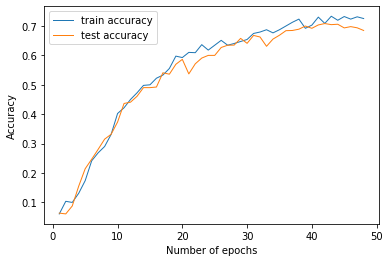

Epoch:  49 ,  test_accuracy:  0.7048132 , training accuracy:  0.73339844 .
Performance:


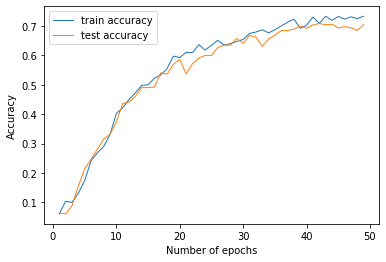

Epoch:  50 ,  test_accuracy:  0.71087176 , training accuracy:  0.7324219 .
Performance:


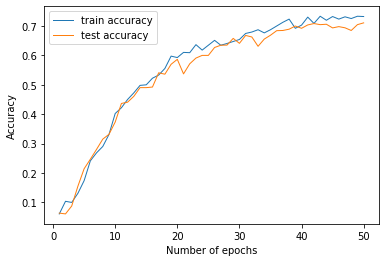

Epoch:  51 ,  test_accuracy:  0.7202962 , training accuracy:  0.7451172 .
Performance:


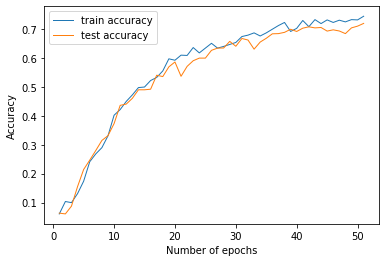

Epoch:  52 ,  test_accuracy:  0.7233255 , training accuracy:  0.7402344 .
Performance:


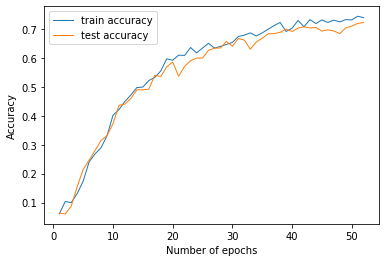

Epoch:  53 ,  test_accuracy:  0.7233255 , training accuracy:  0.76464844 .
Performance:


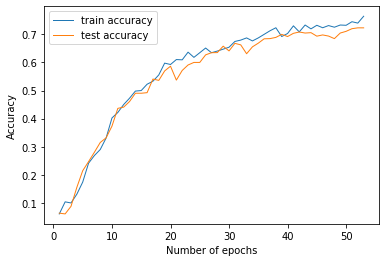

Epoch:  54 ,  test_accuracy:  0.71894985 , training accuracy:  0.74902344 .
Performance:


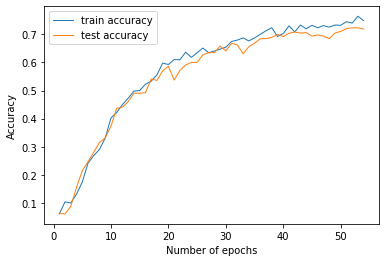

Epoch:  55 ,  test_accuracy:  0.7071693 , training accuracy:  0.7578125 .
Performance:


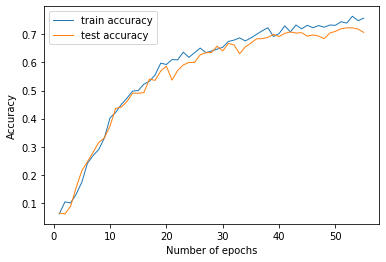

Epoch:  56 ,  test_accuracy:  0.71625715 , training accuracy:  0.7597656 .
Performance:


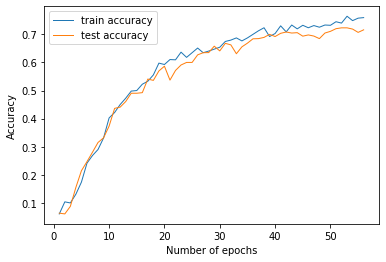

Epoch:  57 ,  test_accuracy:  0.73544264 , training accuracy:  0.74609375 .
Performance:


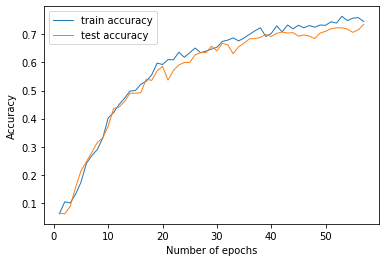

Epoch:  58 ,  test_accuracy:  0.7287109 , training accuracy:  0.7607422 .
Performance:


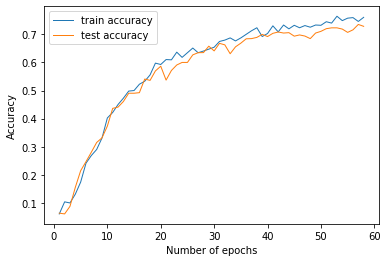

Epoch:  59 ,  test_accuracy:  0.72399867 , training accuracy:  0.7451172 .
Performance:


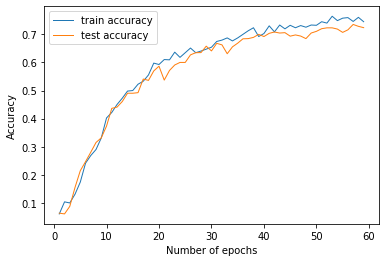

Epoch:  60 ,  test_accuracy:  0.7223157 , training accuracy:  0.74902344 .
Performance:


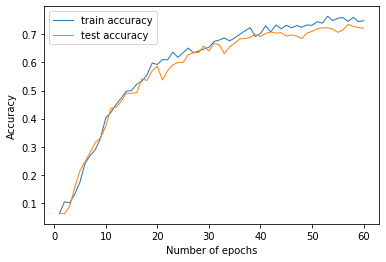

Epoch:  61 ,  test_accuracy:  0.73544264 , training accuracy:  0.77734375 .
Performance:


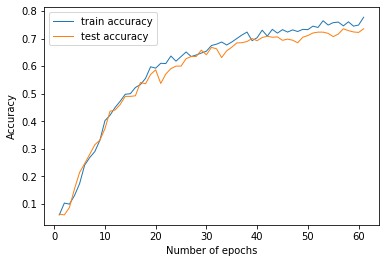

Epoch:  62 ,  test_accuracy:  0.71861327 , training accuracy:  0.7705078 .
Performance:


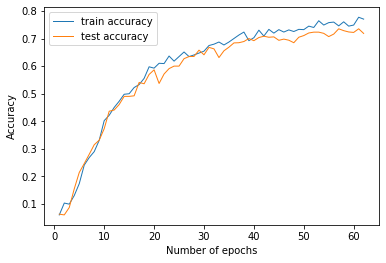

Epoch:  63 ,  test_accuracy:  0.731067 , training accuracy:  0.77246094 .
Performance:


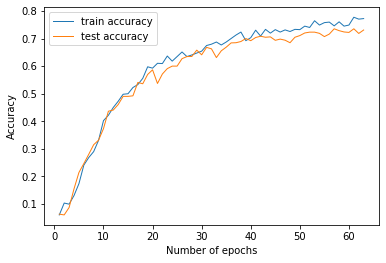

Epoch:  64 ,  test_accuracy:  0.7455402 , training accuracy:  0.78808594 .
Performance:


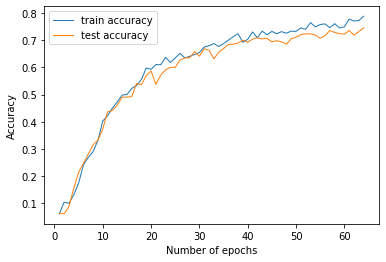

Epoch:  65 ,  test_accuracy:  0.73880845 , training accuracy:  0.77246094 .
Performance:


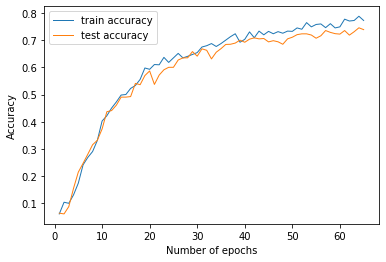

Epoch:  66 ,  test_accuracy:  0.7398182 , training accuracy:  0.78027344 .
Performance:


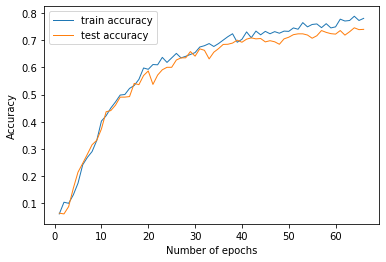

Epoch:  67 ,  test_accuracy:  0.73746216 , training accuracy:  0.796875 .
Performance:


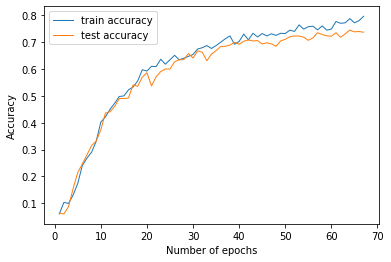

Epoch:  68 ,  test_accuracy:  0.7478963 , training accuracy:  0.7832031 .
Performance:


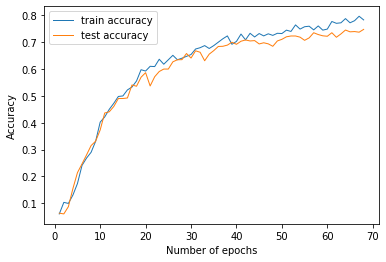

Epoch:  69 ,  test_accuracy:  0.7364524 , training accuracy:  0.7705078 .
Performance:


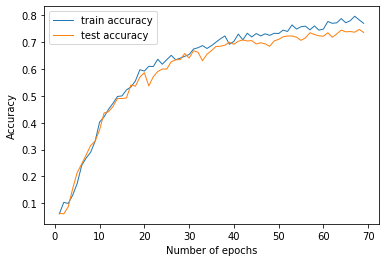

Epoch:  70 ,  test_accuracy:  0.74419385 , training accuracy:  0.7792969 .
Performance:


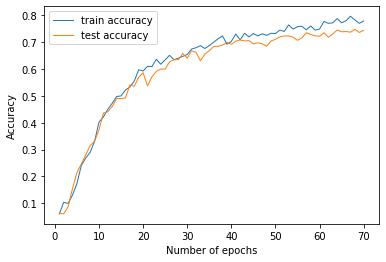

Epoch:  71 ,  test_accuracy:  0.7435207 , training accuracy:  0.7685547 .
Performance:


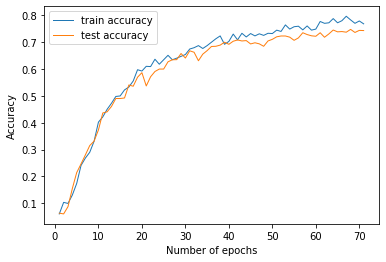

Epoch:  72 ,  test_accuracy:  0.736789 , training accuracy:  0.7988281 .
Performance:


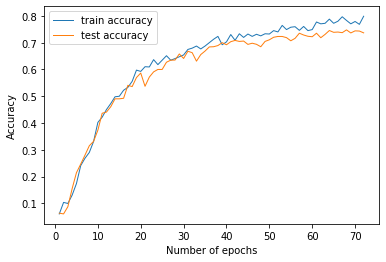

In [ ]:
# Hyperparameters and training
num_epochs=250
batch_size = 1024

learning_rate = 7e-4
classifier =  VGG16_based(learning_rate)


train(num_epochs,batch_size, classifier, dataset)